In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SWE2017 - NLP

## Advanced Linguistic Analyser For Identifying Toxic Online Interactions

## Overview
We aim to build a multi-label classification model that can detect different types of toxicity like threats, obscenity, insults, and identity-based hate. We will use a dataset of comments from Wikipedia's talk page edits, collected by Kaggle. The implementation of this model will improve the social interactions in online forums and social media platforms.


## Installing Packages

In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

import statistics

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Data Preprocessing

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Toxic-Comment-Classification-Challenge-master/Toxic-Comment-Classification-Challenge-master/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Toxic-Comment-Classification-Challenge-master/Toxic-Comment-Classification-Challenge-master/data/test.csv")
test_y = pd.read_csv("/content/drive/MyDrive/Toxic-Comment-Classification-Challenge-master/Toxic-Comment-Classification-Challenge-master/data/test_labels.csv")

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


Notice that the training data contains 159,571 observations with 8 columns and the test data contains 153,164 observations with 2 columns.

In [ ]:
train.shape

(159571, 8)

In [ ]:
test.shape

(153164, 2)

Text(0.5, 1.0, 'Comment Length Frequency')

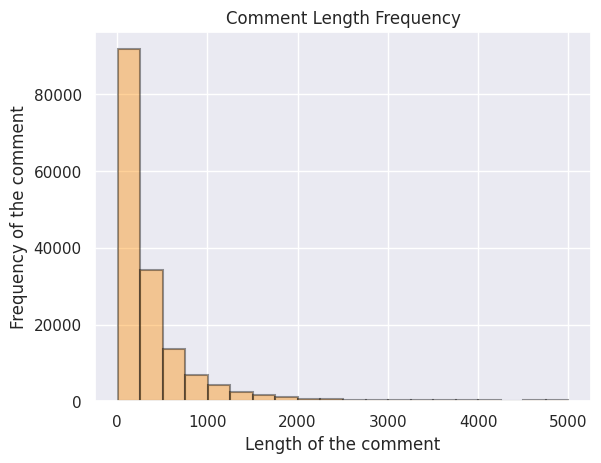

In [ ]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="darkorange", hist_kws={'edgecolor': 'black', 'linewidth': 1.5})
plt.xlabel("Length of the comment")
plt.ylabel("Frequency of the comment")
plt.title("Comment Length Frequency")

> As observed, most of the comments are short with only a few comments longer than 1000 words.

In [ ]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

Text(0, 0.5, 'Frequency')

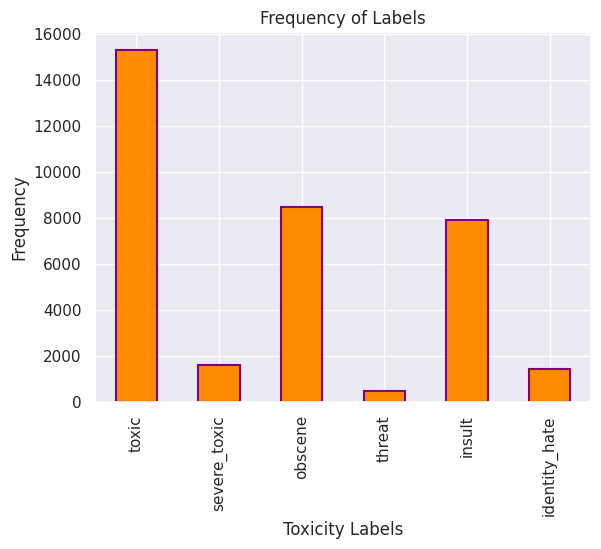

In [ ]:
label_count.plot(kind='bar', title='Frequency of Labels', color='darkorange', edgecolor='purple', linewidth=1.5)
plt.xlabel('Toxicity Labels')
plt.ylabel('Frequency')

> Further we observe that the label `toxic` has the most occurences in the training dataset while `threat` has the least.

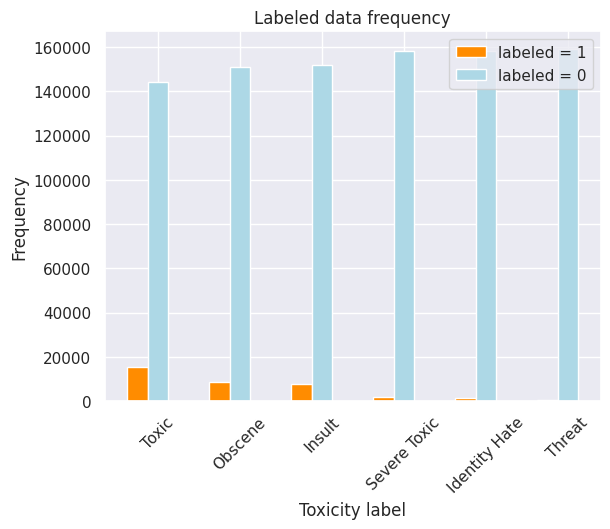

In [ ]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='darkorange', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightblue', width=barWidth, label='labeled = 0')

plt.xlabel('Toxicity label')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat'], rotation=45)
plt.ylabel('Frequency')
plt.title('Labeled data frequency')

plt.legend()
plt.show()

> We observe that there is a significant class imbalance since majority of the comments are considered non-toxic.

In [ ]:
# Example of clean comment
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
# Example of toxic comment
train[train.toxic == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

Now, we can see which labels are likely to appear together with a comment.

<Axes: title={'center': 'Cross correlation matrix'}>

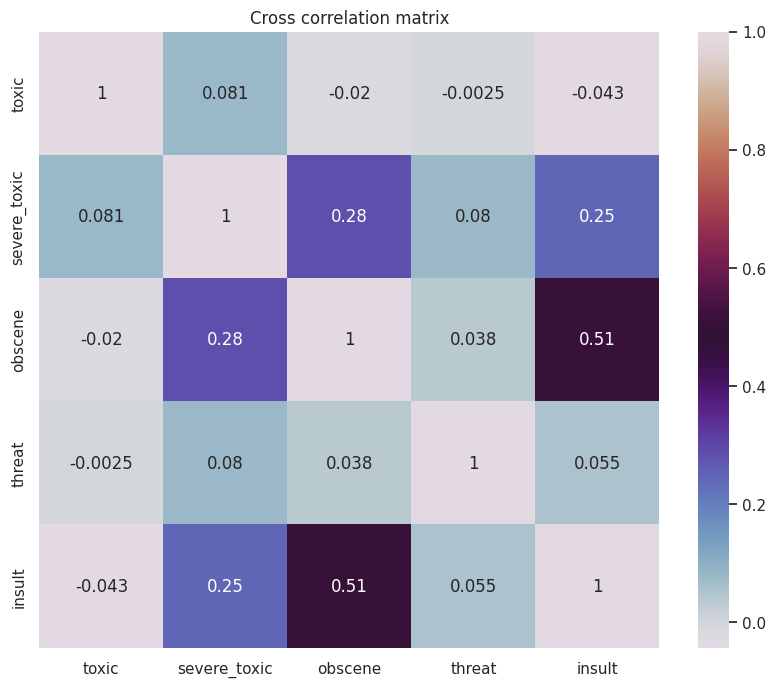

In [ ]:
# Cross correlation matrix across labels
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()

plt.figure(figsize=(10, 8))
plt.title('Cross correlation matrix')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, cmap="twilight")

> As seen in the cross-correlation matrix, there is a high chance of `obscene` comments to be `insulting`.

In order to get an idea of what are the words that contribute the most to different labels, we write a function to generate word clouds. The function takes in a parameter label (i.e., toxic, insult, threat, etc)

In [ ]:
def W_Cloud(token):
    """
    Visualizes the most common words contributing to the token.
    """
    threat_context = train[train[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Purples"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

Choose a class [toxic, severe_toxic, obscene, threat, insult, identity_hate] to visualize the most common words contributing to the class: toxic


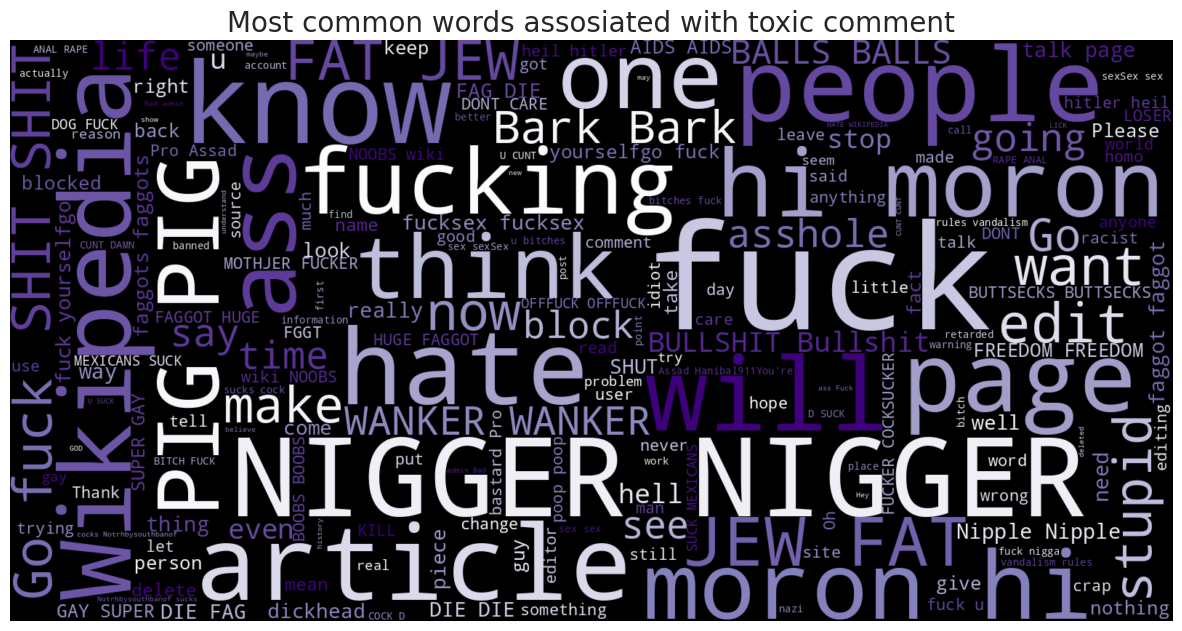

In [ ]:
# an interactive visual
token = input(
    'Choose a class [toxic, severe_toxic, obscene, threat, insult, identity_hate] to visualize the most common words contributing to the class: ')
W_Cloud(token.lower())

<a id='Feature-engineering'></a>
## Feature-engineering

Before fitting models, we need to break down the sentence into unique words by tokenizing the comments. In the `tokenize()` function, we remove punctuations and special characters. We also filtered out non-ascii characters after observing the results of feature engineering. We then lemmatize the comments and filter out comments with length below 3. Besides lemmatization, we also tried stemming but did not get a better result.

In [ ]:
test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [ ]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text.
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

#### Benchmarking Different Vectorizer

We determined to use TF-IDF to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

Besides TF-IDF, we also tried CountVectorizer. However, it is not performing as well as TF-IDF. The TfidfVectorizer is actually CountVectorizer followed by TfidfTransformer. TfidfTransformer transforms a count matrix to a normalized Term-Frequency or TermFrequency-InverseDocumentFrequency representation. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. That's why we can improve the accuracy here.

For example: Since this corpus consists of data from the Wikipedia's talk page edits, the words such as wiki, Wikipedia, edit, page are very common. But for our classification purposes they do not provide us useful information and that should probably be the reason why TF-IDF worked better than CountVectorizer.

In [ ]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=True, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

After the transformation, we can take a look at some of the features below.

In [ ]:
vector.get_feature_names_out()[0:20]

array(['aaa', 'aap', 'aardvark', 'aaron', 'aba', 'abandon', 'abandoned',
       'abandoning', 'abandonment', 'abbas', 'abbey', 'abbott',
       'abbreviated', 'abbreviation', 'abc', 'abcnews', 'abd', 'abducted',
       'abduction', 'abdul'], dtype=object)

<a id='Modeling'></a>
## Modeling and Evaluation

### Baseline Model

We choose Naive Bayes as our baseline model, specifically Multinomial Naive Bayes.

Also, we want to compare between different models, especially models that perform well in text classification. Thus, we choose to compare Multinomial Naive Bayes with Logistic Regression and Linear Support Vector Machine.

### Evaluation Metrics

Our main metric for measuring model performance is F1-score, since we have 6 labels, the F1-score would be the average of 6 labels. We will also take other metrics into consideration while evaluating models, e.g, Hamming loss and recall.

<a id='cv'></a>
### Cross Validation

We use cross Validation to compare between the baseline model and the other two models that we have chosen (LogisticRegression and LinearSVC).

In [ ]:
# Creating classifiers with default parameters initially.
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [ ]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the cross validation F1 and Recall score
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [ ]:
# Calculating the cross validation F1 and Recall score for our 3 baseline models.
methods1_cv = pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [ ]:
# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.483195,0.636792
1,MultinomialNB,severe_toxic,0.021938,0.042208
2,MultinomialNB,obscene,0.469404,0.622365
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,insult,0.367146,0.511481
5,MultinomialNB,identity_hate,0.007832,0.015346
6,LogisticRegression,toxic,0.616516,0.734597
7,LogisticRegression,severe_toxic,0.255181,0.351982
8,LogisticRegression,obscene,0.638540,0.747416
9,LogisticRegression,threat,0.131605,0.218787


Now we can see how these 3 models perform on the test dataset.

### ⚔ Modeling and Evaluation

In [ ]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        methods.append([name, label, recall, f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])
    hloss.append([name, hamming_loss_score])

    return hloss, methods

In [ ]:
# Calculating the Hamming-loss F1 and Recall score for our 3 baseline models.
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [ ]:
# Creating a dataframe to show summary of results.
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1 Score', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1 Score']]

,Model,Label,Recall,F1 Score
0,MultinomialNB,toxic,0.935181,0.930925
1,MultinomialNB,severe_toxic,0.994436,0.992145
2,MultinomialNB,obscene,0.962987,0.957910
3,MultinomialNB,threat,0.996702,0.995056
4,MultinomialNB,insult,0.960127,0.953437
5,MultinomialNB,identity_hate,0.988887,0.983408
6,LogisticRegression,toxic,0.935603,0.936960
7,LogisticRegression,severe_toxic,0.993107,0.992796
8,LogisticRegression,obscene,0.965754,0.964088
9,LogisticRegression,threat,0.996374,0.995736


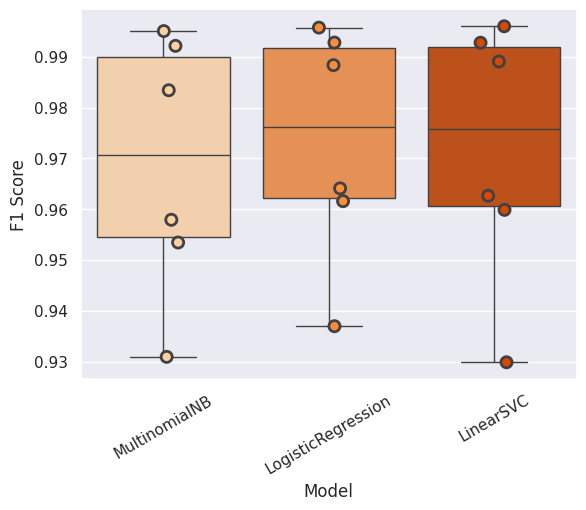

In [ ]:
# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='Model', y='F1 Score', data=methods, palette="Oranges")
sns.stripplot(x='Model', y='F1 Score', data=methods, size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Oranges")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.show()

### Visualizing performance till now for each classifier across each category

Plot for F1 Score & Recall across each label for Multinomial Naive Bayes


<Axes: title={'center': 'Plot for F1 Score & Recall across each label for Multinomial Naive Bayes'}, xlabel='Label'>

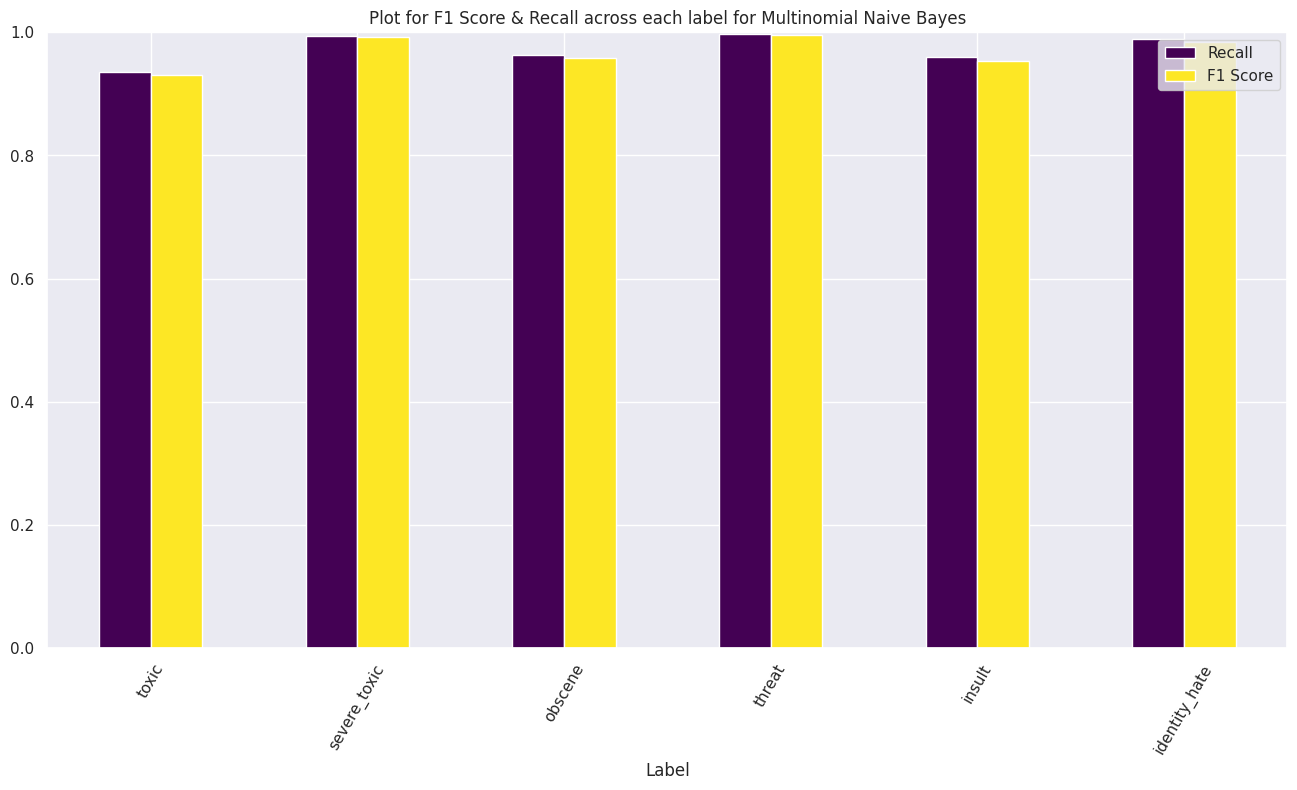

In [ ]:
print("Plot for F1 Score & Recall across each label for Multinomial Naive Bayes")
m2 = methods[methods.Model == 'MultinomialNB']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Plot for F1 Score & Recall across each label for Multinomial Naive Bayes',
        rot=60, ylim=(0.0, 1), colormap='viridis')

Plot for F1 Score & Recall across each label for Logistic regression


<Axes: title={'center': 'Plot for F1 Score & Recall across each label for Logistic regression'}, xlabel='Label'>

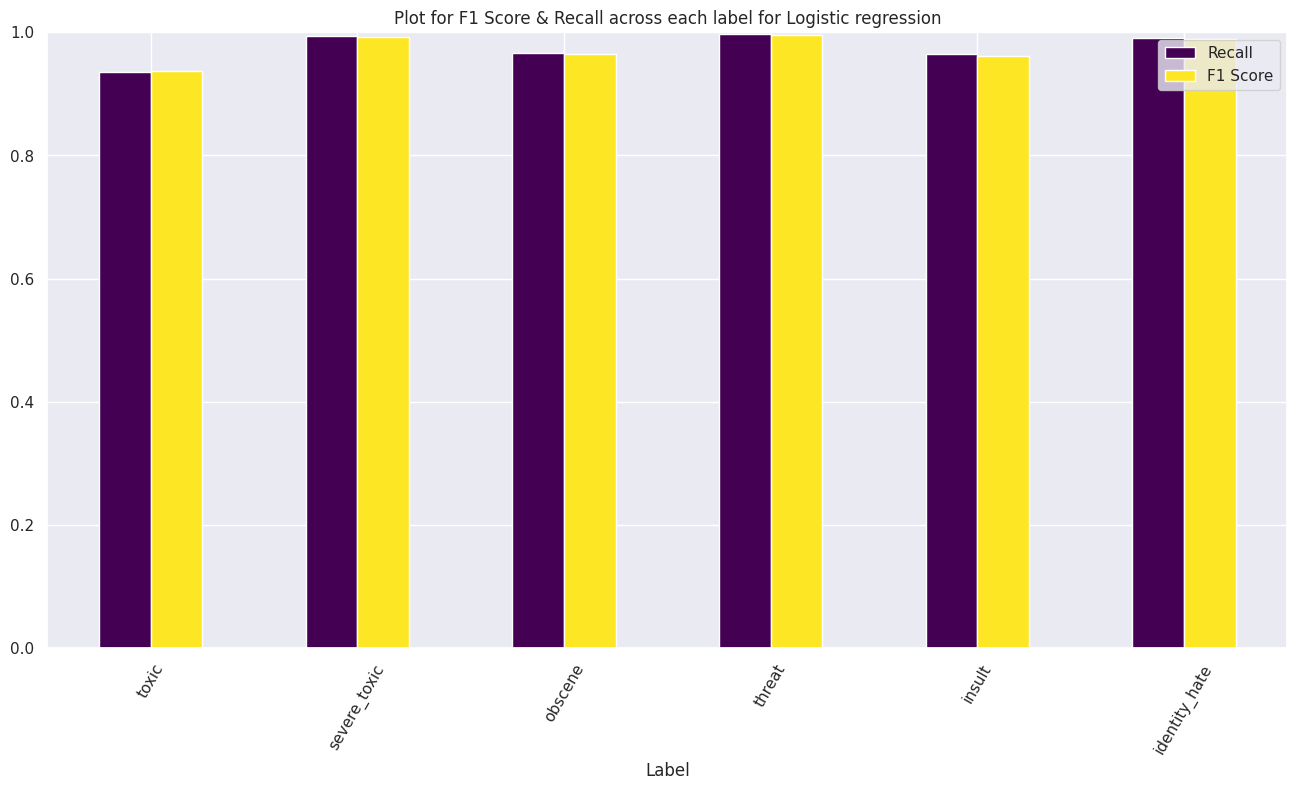

In [ ]:
print("Plot for F1 Score & Recall across each label for Logistic regression")
m2 = methods[methods.Model == 'LogisticRegression']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Plot for F1 Score & Recall across each label for Logistic regression',
        rot=60, ylim=(0.0, 1), colormap='viridis')


Plot for F1 Score & Recall across each label for Linear SVC


<Axes: title={'center': 'Plot for F1 Score & Recall across each label for Linear SVC'}, xlabel='Label'>

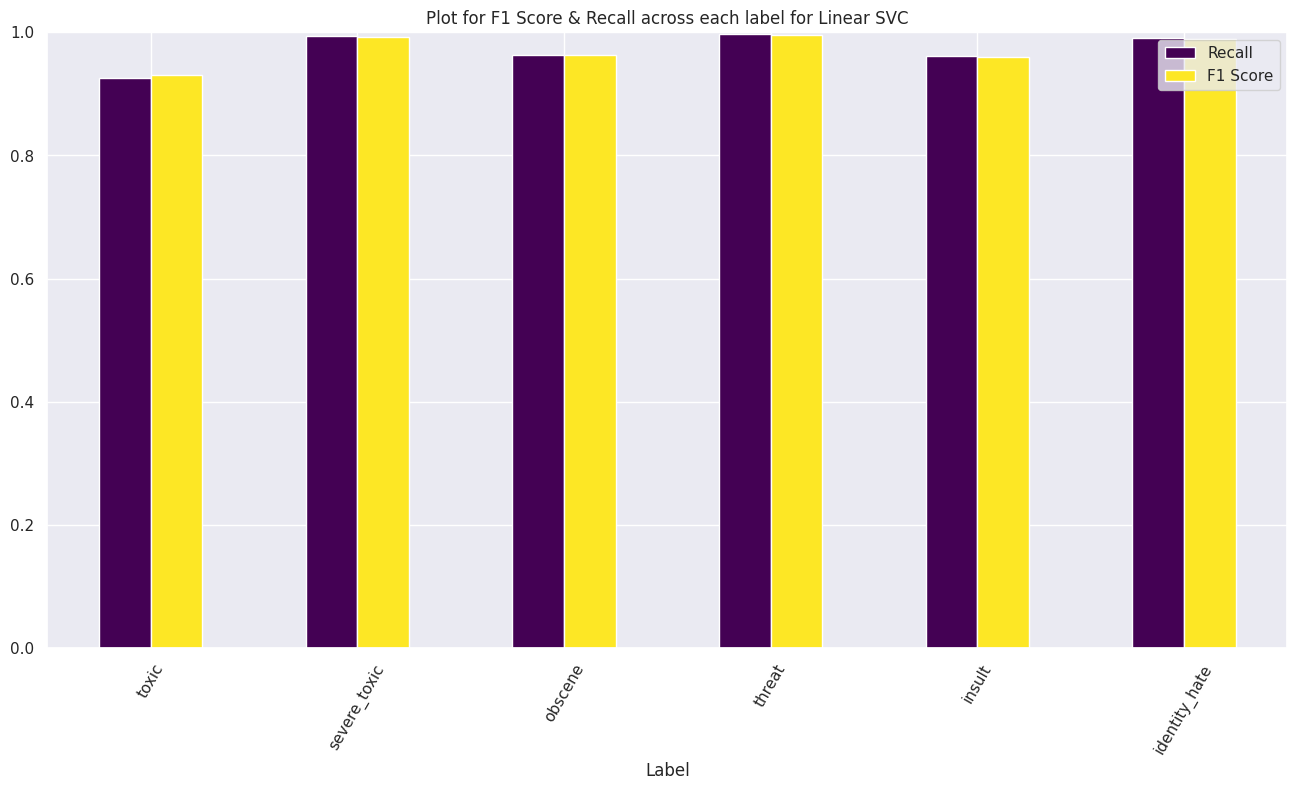

In [ ]:
print("Plot for F1 Score & Recall across each label for Linear SVC")
m2 = methods[methods.Model == 'LinearSVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Plot for F1 Score & Recall across each label for Linear SVC',
        rot=60, ylim=(0.0, 1), colormap='viridis')


<a id='model-comparison'></a>
###  Confusion Matrix visualization

In [ ]:
def drawConfusionMatrix(cm):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 16},
                cmap="Oranges",
                fmt='.2f',
                linewidths=2,
                linecolor='darkorange',
                xticklabels=("Non-toxic", "Toxic"),
                yticklabels=("Non-toxic", "Toxic"))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.show()

In [ ]:
def Matrix(label):
    """
    Plot Confusion matrix for each label and call function drawConfusionMatrix().
    """
    print(f"*************** {label} labelling ***************")
    labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2,
              "threat": 3, "insult": 4, "identity_hate": 5}

    pos = labels[label]
    for i in range(pos, len(meth), 6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Below shows the confusion matrix for label `insult`. Notice that all models predict Non-toxic labels pretty well because most of our data are non-toxic. However, Multinomial NB tends to predict more toxic comments to non-toxic while Linear SVC is doing a great job in classifying toxic comments.

Choose a class for the Confusion Matrix [toxic, severe_toxic, obscene, threat, insult, identity_hate]: threat
*************** threat labelling ***************

****  MultinomialNB  ***


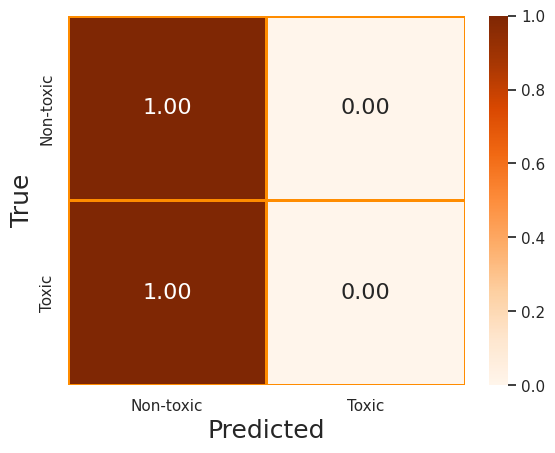


****  LogisticRegression  ***


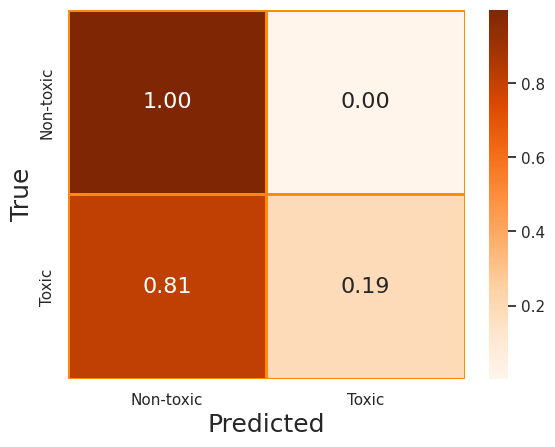


****  LinearSVC  ***


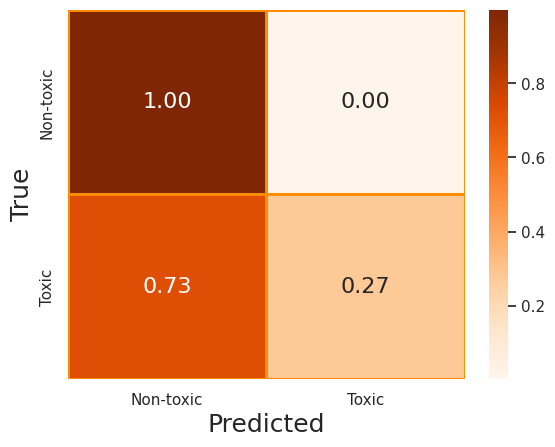

In [ ]:
token = input('Choose a class for the Confusion Matrix [toxic, severe_toxic, obscene, threat, insult, identity_hate]: ')
Matrix(token.lower())

Based on the above comparison, we could say that for these three models with default settings, **LinearSVC performs better for the 'insult' label .**




### Aggregated Hamming Loss Score


In [ ]:
# Creating a dataframe to summarize Hamming-loss
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [ ]:
hammingloss = pd.concat([hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

,Model,Hamming_Loss
0,MultinomialNB,0.026947
1,LogisticRegression,0.025725
2,LinearSVC,0.028484


Across all models , **Logistic Regression** is doing a great job overall since it has the lowest percentage of incorrect labels.

<a id='pipeline'></a>
### Pipelines
So far we have only compared models without any hyperparameter tuning. Let's clean the code with pipeline and use some manually chosen hyperparameters to check how each model behaves. Since the greatest concern now is the imbalanced data, we decide to manually adjust `class_weight` for the models to see if we can achieve better results.

Since Logistic Regression and Linear SVM are performing better, we will focus on these two models. For display purpose, we will only include average F1 score, Recall, and Hamming Loss for comparison.

In [ ]:
pipe_lr = Pipeline([
    ('lr', LogisticRegression(class_weight="balanced"))
])

pipe_linear_svm = Pipeline([
    ('svm', LinearSVC(class_weight={1: 20}))
])

pipelines = [pipe_lr, pipe_linear_svm]

In [ ]:
score_df = []
for pipe in pipelines:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    for label in test_labels:
        start = timer()
        pipe.fit(X_train, train[label])
        train_time = timer() - start
        predicted = pipe.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted"))
        recall_values.append(recall_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted"))
        training_time.append(train_time)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]

    hamming_loss_score = hamming_loss(
        test_y[test_y['toxic'] != -1].iloc[:, 1:7], predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]
    score_df.append(val)

In [ ]:
scores = pd.DataFrame(score_df,)
scores.columns = ['Model', 'F1', 'Recall', 'Hamming_Loss', 'Training_Time']
scores

,Model,F1,Recall,Hamming_Loss,Training_Time
0,LogisticRegression,0.947224,0.932907,0.067093,1.572927
1,LinearSVC,0.951540,0.941678,0.058322,3.420038


Notice that after adjusting `class_weight`, we are getting way better results than the basic models. LogisticRegression   outperforms LinearSVC by approximately 1%.

<a id='Tuning'></a>
## Hyperparameter Tuning with Grid Search

Now we decide to do grid search to seek for the "optimal" hyperparameters for the basic models that we've chose. Later we will make comparison based on the best model from each algorithm, since we have 6 different lables, tuning models for each label would be time expensive, so we will use the most common label "Toxic" to tune hyperparameters.

<a id='lr-tuning'></a>
### Logistic Regression Tuning

In [ ]:
logistic_regression_classifier = LogisticRegression()

parameter_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  'class_weight': [None, 'balanced']}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'class_weight': None, 'solver': 'lbfgs'}


LogisticRegression()

<a id='svm-tuning'></a>
### SVM Classifier Tuning

In [ ]:
svm_classifier = LinearSVC()

parameter_grid = {'class_weight': [None, 'balanced'],
                  'C': [1, 5, 10]}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svm_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'C': 1, 'class_weight': None}


LinearSVC(C=1)

###  Model Selection

We will then compare these two models based on their tunned hyperparameters, we will also include training time as one of the metric when we compare models.

In [ ]:
svm_clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                    verbose=0)

lr_clf = lr_clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                     intercept_scaling=1, max_iter=100, multi_class='auto',
                                     n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                                     tol=0.0001, verbose=0, warm_start=False)

tunned_model_score_df = []
for model in [svm_clf, lr_clf]:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        start = timer()
        model.fit(X_train, train[label])
        training_time.append(timer() - start)
        predicted = model.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, sum(training_time)]

    tunned_model_score_df.append(val)

In [ ]:
tunned_scores = pd.DataFrame(tunned_model_score_df,)
tunned_scores.columns = ['Model', 'F1',
                         'Recall', 'Hamming_Loss', 'Traing_Time']
tunned_scores

,Model,F1,Recall,Hamming_Loss,Traing_Time
0,LinearSVC,0.971704,0.971521,0.028479,4.542250
1,LogisticRegression,0.973250,0.974275,0.025725,11.408051


<a id='Ensembling'></a>
## Ensembling

Since Ensemble learning helps improve machine learning results by combining several models and allows the production of better predictive performance compared to a single model, we want to see if ensembling could help us achieve better results.

To ensemble different models, we firstly tried some models based on tree boosting, then use a voting classfier to ensemble one of the boosting model with the basic models in previous parts.

<a id='boosting'></a>
### Boosting Models

We tried 3 popular tree-based boosting models, and make a comparison for those models.

In [ ]:
ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier()
boosting_models = [ab_clf, gb_clf, xgb_clf]

In [ ]:
boosting_score_df = []
for model in boosting_models:
    f1_values = []
    recall_values = []
    training_time = []
    hloss = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for idx, label in enumerate(test_labels):
        start = timer()
        model.fit(X_train, train[label])
        predicted = model.predict(X_test)
        training_time.append(timer() - start)
        predict_df[label] = predicted
        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]

    boosting_score_df.append(val)

### Scores After Boosting the Model

In [ ]:
boosting_score = pd.DataFrame(boosting_score_df,)
boosting_score.columns = ['Model', 'F1',
                          'Recall', 'Hamming_Loss', 'Traing_Time']
boosting_score

,Model,F1,Recall,Hamming_Loss,Traing_Time
0,AdaBoostClassifier,0.956865,0.966074,0.033926,55.862631
1,GradientBoostingClassifier,0.969122,0.971732,0.028268,244.074742
2,XGBClassifier,0.972728,0.973204,0.026796,69.608247


Since XGBoost outperforms other two boosting models, we go ahead with XGBoost

<a id='voting'></a>
### VotingClassifier

In [ ]:
# pip install --upgrade scikit-learn xgboost

In [ ]:
# ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf),
#                                             ('svm', svm_clf),
#                                             ('xgb', xgb_clf)], voting='hard')
# ensemble_score_df = []
# f1_values = []
# recall_values = []
# hl = []
# training_time = []

# predict_df = pd.DataFrame()
# predict_df['id'] = test_y['id']
# for label in test_labels:
#     start = timer()
#     ensemble_clf.fit(X_train, train[label])
#     training_time.append(timer() - start)
#     predicted = ensemble_clf.predict(X_test)
#     predict_df[label] = predicted
#     f1_values.append(f1_score(test_y[test_y[label] != -1][label],
#                               predicted[test_y[label] != -1],
#                               average="weighted"))
#     recall_values.append(recall_score(test_y[test_y[label] != -1][label],
#                                       predicted[test_y[label] != -1],
#                                       average="weighted"))
#     name = 'Ensemble'

# hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
#                                   predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

# val = [name, mean(f1_values), mean(recall_values),
#        hamming_loss_score, mean(training_time)]
# ensemble_score_df.append(val)


# # printing the values
# ensemble_score = pd.DataFrame(ensemble_score_df,)
# ensemble_score.columns = ['Model', 'F1',
#                           'Recall', 'Hamming_Loss', 'Training_Time']
# ensemble_score

AttributeError: 'super' object has no attribute '__sklearn_tags__'

 Ensembled model worked very well and outperformed Logistic Regression producing a better F1 score

# MY VOTING CLASSIFIER CODE

In [ ]:
!pip install tqdm psutil

Evaluating models...

Final Model Comparison:
                Model        F1    Recall  Hamming_Loss  Training_Time
0                 SVM  0.971699  0.971516      0.028484      13.787428
1  LogisticRegression  0.973250  0.974275      0.025725      13.100640
2             XGBoost  0.972728  0.973204      0.026796     418.847336
3            Ensemble  0.973405  0.974059      0.025941       0.313582


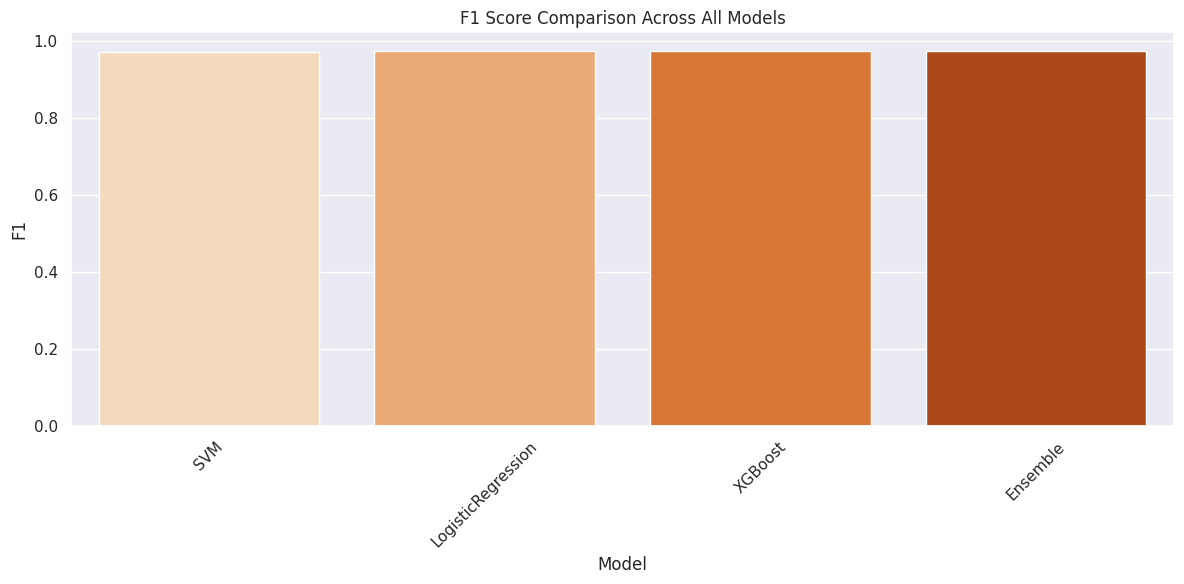

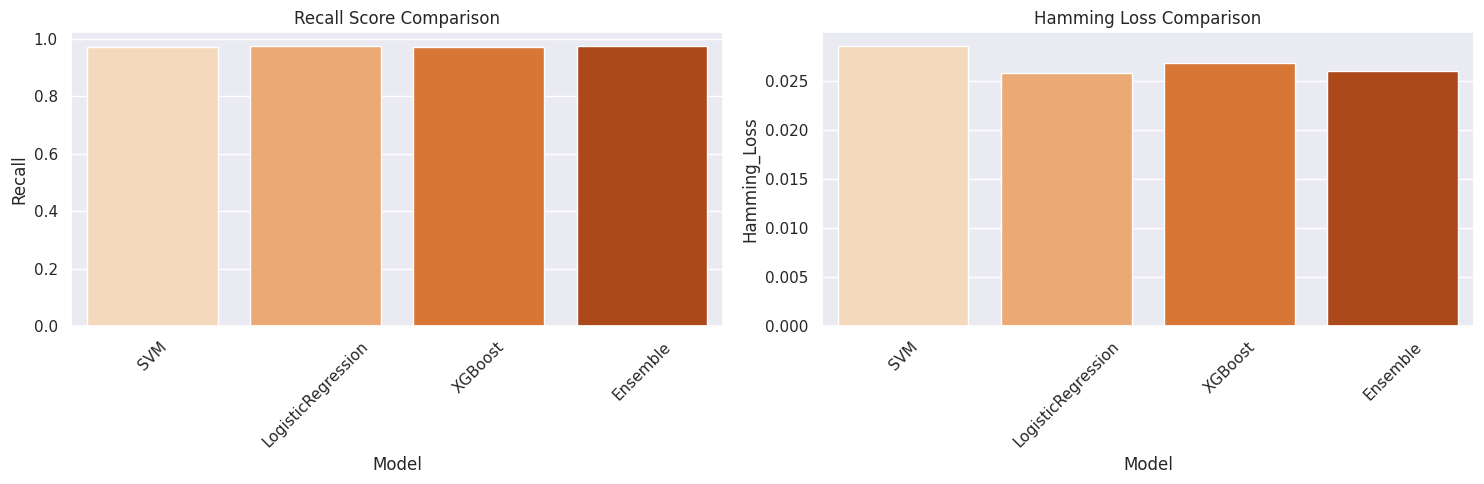

In [ ]:
import numpy as np
from timeit import default_timer as timer
from statistics import mean
from sklearn.metrics import f1_score, recall_score, hamming_loss
from sklearn.base import clone

def majority_vote(predictions):
    """
    Perform majority voting across model predictions
    """
    return np.round(np.mean(predictions, axis=0))

def evaluate_models(X_train, train, X_test, test_y):
    """
    Evaluate individual models and their ensemble
    """
    # Initialize base models
    models = {
        'SVM': LinearSVC(C=1, class_weight=None, random_state=42),
        'LogisticRegression': LogisticRegression(solver='lbfgs', class_weight=None, random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42)
    }

    results = []
    ensemble_predictions = {}

    # Evaluate individual models
    for model_name, model in models.items():
        start = timer()
        f1_values = []
        recall_values = []
        predictions_by_label = {}

        for label in test_labels:
            # Clone model for each label to ensure fresh fit
            model_clone = clone(model)
            model_clone.fit(X_train, train[label])
            predictions = model_clone.predict(X_test)
            predictions_by_label[label] = predictions

            # Calculate metrics only on non-missing labels
            mask = test_y[label] != -1
            f1 = f1_score(test_y[mask][label], predictions[mask], average="weighted")
            recall = recall_score(test_y[mask][label], predictions[mask], average="weighted")
            f1_values.append(f1)
            recall_values.append(recall)

        training_time = timer() - start

        # Store predictions for ensemble
        ensemble_predictions[model_name] = predictions_by_label

        # Calculate hamming loss
        predict_df = pd.DataFrame({'id': test_y['id']})
        for label in test_labels:
            predict_df[label] = predictions_by_label[label]

        hamming_loss_score = hamming_loss(
            test_y[test_y['toxic'] != -1].iloc[:, 1:7],
            predict_df[test_y['toxic'] != -1].iloc[:, 1:7]
        )

        results.append({
            'Model': model_name,
            'F1': mean(f1_values),
            'Recall': mean(recall_values),
            'Hamming_Loss': hamming_loss_score,
            'Training_Time': training_time
        })

    # Calculate ensemble predictions and metrics
    start = timer()
    ensemble_f1_values = []
    ensemble_recall_values = []
    ensemble_predictions_df = pd.DataFrame({'id': test_y['id']})

    for label in test_labels:
        # Gather predictions from all models for this label
        label_predictions = np.array([
            ensemble_predictions[model_name][label]
            for model_name in models.keys()
        ])

        # Calculate ensemble prediction using majority voting
        ensemble_pred = majority_vote(label_predictions)
        ensemble_predictions_df[label] = ensemble_pred

        # Calculate metrics only on non-missing labels
        mask = test_y[label] != -1
        f1 = f1_score(test_y[mask][label], ensemble_pred[mask], average="weighted")
        recall = recall_score(test_y[mask][label], ensemble_pred[mask], average="weighted")
        ensemble_f1_values.append(f1)
        ensemble_recall_values.append(recall)

    ensemble_time = timer() - start

    # Calculate ensemble hamming loss
    ensemble_hamming_loss = hamming_loss(
        test_y[test_y['toxic'] != -1].iloc[:, 1:7],
        ensemble_predictions_df[test_y['toxic'] != -1].iloc[:, 1:7]
    )

    # Add ensemble results
    results.append({
        'Model': 'Ensemble',
        'F1': mean(ensemble_f1_values),
        'Recall': mean(ensemble_recall_values),
        'Hamming_Loss': ensemble_hamming_loss,
        'Training_Time': ensemble_time
    })

    return pd.DataFrame(results)

# Run evaluation
print("Evaluating models...")
results_df = evaluate_models(X_train, train, X_test, test_y)
print("\nFinal Model Comparison:")
print(results_df)

# Visualize results
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1', data=results_df, palette='Oranges')
plt.title('F1 Score Comparison Across All Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot additional metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x='Model', y='Recall', data=results_df, palette='Oranges', ax=axes[0])
axes[0].set_title('Recall Score Comparison')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Model', y='Hamming_Loss', data=results_df, palette='Oranges', ax=axes[1])
axes[1].set_title('Hamming Loss Comparison')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Results Interpretation
### 🤔 What went wrong?

Analyzing the words misclassified by Logistic Classifier. Checking for 'toxic' label


In [ ]:
label = 'toxic'
lr = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
               intercept_scaling=1, loss='squared_hinge', max_iter=1000,
               multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
               verbose=0)
lr.fit(X_train, train[label])
Toxic_LR = lr.predict(X_test)
test_combined = pd.concat([test, test_y], axis=1)

In [ ]:
commentCheck = test_combined[(test_combined.toxic == 1) & (
    Toxic_LR == 0)].comment_text
commentCheck.shape

(1347,)

- Misclassified 1347 as non-toxic which were actually toxic

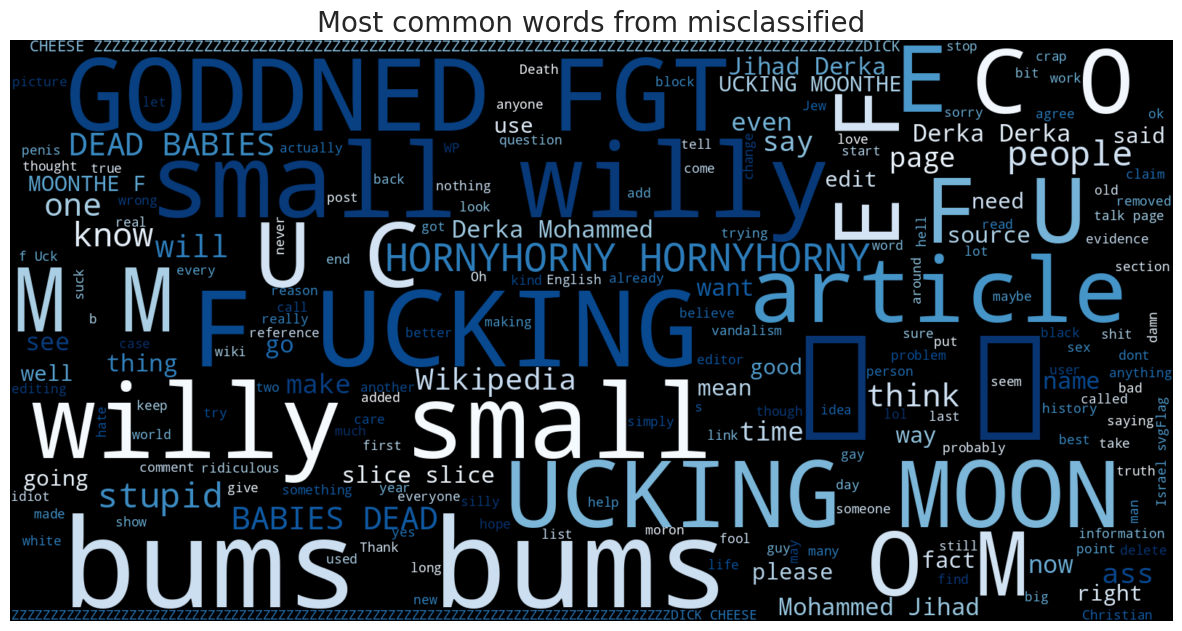

In [ ]:
# extract wrongly classified comments
commentCheck = test_combined[(test_combined.toxic == 1) & (
    Toxic_LR == 0)].comment_text

neg_Check = pd.Series(commentCheck).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,
                      max_font_size=200).generate(neg_Check)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title("Most common words from misclassified", size=20)
plt.show()

- We want to analyze why the model couldn't recognize these words. Were they not present in the training set?
- In order to analyze, we first need to pass these raw comment strings through same tokenizer and check the common tokens.

In [ ]:
# wrongWords = tokenize(neg_Check)
# stop_words = stopwords.words('English')
# wrongWords = [w for w in wrongWords if w not in stop_words]
# cntr = Counter(wrongWords)
# cntr.most_common(20)

In [ ]:
import nltk

# Download the stopwords resource
nltk.download('stopwords')

# Now you can load the stopwords
wrongWords = tokenize(neg_Check)
stop_words = stopwords.words('english')  # Changed 'English' to 'english'
wrongWords = [w for w in wrongWords if w not in stop_words]
cntr = Counter(wrongWords)
cntr.most_common(20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('bum', 352),
 ('ucking', 253),
 ('small', 244),
 ('willy', 238),
 ('goddned', 226),
 ('fgt', 226),
 ('moon', 200),
 ('like', 184),
 ('article', 184),
 ('hornyhorny', 174),
 ('stupid', 142),
 ('people', 142),
 ('derka', 140),
 ('dead', 134),
 ('know', 132),
 ('baby', 129),
 ('one', 122),
 ('wikipedia', 119),
 ('page', 116),
 ('think', 116)]

`ucking` is a common word in the test set and it seems our classifier hasnt learnt to classify it as toxic. Let's check how frequent was this word in the training data.

In [ ]:
neg_text_train = train['comment_text'].str.cat(sep=' ')
cntr_train = Counter(tokenize(neg_text_train))
cntr_train.get('ucking')

5

It is interesting to note that this token wasn't common in our training set. That explains why our model couldn't learn it.
It also gives us some food for thought on how we can improve our model further.

Let's see the features and whether this word has a high feature importance.

### 👓 Visual check how logistic learns

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plot learning rate curve for the estimator with title, training data as X,
    labels as y.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="olive",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

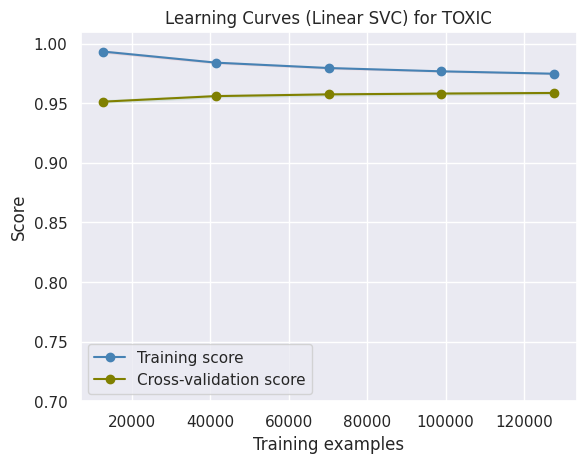

In [ ]:
title = "Learning Curves (Linear SVC) for TOXIC"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                      verbose=0)
plot_learning_curve(estimator, title, X_train,
                    train['toxic'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

## Future Improvements

 - Try more ways of vectorizing text data.
 - Go deeper on feature engineering : Spelling corrector, Sentiment scores, n-grams, etc.
 - Advanced models (e.g., lightgbm).
 - Advanced Ensemble model (e.g., stacking).
 - Deep learning model (e.g., LSTM).
 - Advanced hyperparameter tuning techniques (e.g., Bayesian Optimization).

# NEW CODE:

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [4]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import additional required libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, hamming_loss
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from textblob import TextBlob
import spacy
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Sequential
import xgboost as xgb
from tqdm import tqdm
import optuna
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

class EnhancedToxicCommentClassifier:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.nlp = spacy.load('en_core_web_sm')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def preprocess_text(self, text):
        """Enhanced text preprocessing with additional features"""
        # Basic cleaning
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)

        # SpaCy processing
        doc = self.nlp(text)

        # Extract named entities
        entities = [ent.label_ for ent in doc.ents]

        # Extract POS tags
        pos_tags = [token.pos_ for token in doc]

        # Sentiment analysis
        sentiment = TextBlob(text).sentiment.polarity

        # Word embeddings
        tokens = [token.text for token in doc]

        return {
            'cleaned_text': ' '.join(tokens),
            'entities': entities,
            'pos_tags': pos_tags,
            'sentiment': sentiment
        }

class BERTToxicClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(BERTToxicClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

class ToxicCommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(self.labels[idx])
        }

class LSTMToxicClassifier:
    def __init__(self, max_words=10000, max_len=200, embedding_dim=100):
        self.max_words = max_words
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.model = None

    def build_model(self, vocab_size):
        model = Sequential([
            Embedding(vocab_size, self.embedding_dim, input_length=self.max_len),
            LSTM(128, return_sequences=True),
            LSTM(64),
            Dense(32, activation='relu'),
            Dropout(0.5),
            Dense(6, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model
        return model

def objective(trial, X_train, y_train):
    """Optuna hyperparameter optimization"""
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_macro').mean()
    return score

def train_model(classifier, train_loader, valid_loader, epochs=3):
    """Train the BERT classifier"""
    optimizer = AdamW(classifier.parameters(), lr=2e-5)
    criterion = nn.BCEWithLogitsLoss()
    classifier = classifier.to(device)

    for epoch in range(epochs):
        classifier.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = classifier(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        classifier.eval()
        val_loss = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = classifier(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predictions.extend(outputs.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        predictions = np.array(predictions) >= 0.5
        true_labels = np.array(true_labels)
        f1 = f1_score(true_labels, predictions, average='macro')

        print(f'Epoch {epoch + 1}:')
        print(f'Average training loss: {total_loss / len(train_loader)}')
        print(f'Average validation loss: {val_loss / len(valid_loader)}')
        print(f'Validation F1-score: {f1}')

def create_ensemble():
    """Create an ensemble of different models"""
    models = [
        ('bert', BERTToxicClassifier()),
        ('lstm', LSTMToxicClassifier()),
        ('xgb', xgb.XGBClassifier())
    ]
    return VotingClassifier(estimators=models, voting='soft')

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    classifier = EnhancedToxicCommentClassifier()

    # Load your data
    train_data = pd.read_csv("/content/drive/MyDrive/Toxic-Comment-Classification-Challenge-master/Toxic-Comment-Classification-Challenge-master/data/train.csv")
    test_data = pd.read_csv("/content/drive/MyDrive/Toxic-Comment-Classification-Challenge-master/Toxic-Comment-Classification-Challenge-master/data/test.csv")

    # Preprocess all texts
    processed_train = [classifier.preprocess_text(text) for text in train_data['comment_text']]
    processed_test = [classifier.preprocess_text(text) for text in test_data['comment_text']]

    # Create features
    train_features = pd.DataFrame([{
        'text': p['cleaned_text'],
        'num_entities': len(p['entities']),
        'sentiment': p['sentiment'],
        'num_nouns': p['pos_tags'].count('NOUN')
    } for p in processed_train])

    # Prepare labels
    labels = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

    # Create datasets
    train_dataset = ToxicCommentDataset(
        train_features['text'].values,
        labels.values,
        classifier.tokenizer
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize and train models
    bert_classifier = BERTToxicClassifier()
    lstm_classifier = LSTMToxicClassifier()

    # Train BERT model
    train_model(bert_classifier, train_loader, valid_loader)

    # Optimize XGBoost with Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

    # Create and train ensemble
    ensemble = create_ensemble()
    ensemble.fit(X_train, y_train)

    # Evaluate
    y_pred = ensemble.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f'Final Ensemble F1-score: {f1}')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
